In [3]:
#a fresh Python environment
!pip install --force-reinstall --no-cache-dir numpy==1.24.3 scipy==1.10.1 gensim==4.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 290.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of pyfume to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 28.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 118.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 188.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.2/63.2 kB 263.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 192.3 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 290.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.1/114.1 kB 307.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 3

### Installed required packages

 ## IMPORTS & SETUP

In [7]:
import re, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


## Defining path, and random seed for randomization

In [8]:
CSV_PATH = "/kaggle/input/reviews/reviews.csv"
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading reviews dataset, spliting the dataset as train, test, randomly, 80-20 split

In [9]:
print("Loading data...")
df = pd.read_csv(CSV_PATH).dropna(subset=["Text"]).reset_index(drop=True)
X_all = df["Text"].astype(str).tolist()
y_all = df["Sentiment"].astype(int).to_numpy()

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=SEED, stratify=y_all
)
print(f"✓ {len(X_train_text)} train | {len(X_test_text)} test\n")

Loading data...
✓ 40000 train | 10000 test



## Simple neural network using pytorch

In [10]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x)).squeeze(1)
        return x

## Training function

In [11]:
def train_model(X_train, X_test, y_train, y_test):
    """Train and evaluate model"""
    # Convert to tensors
    X_tr = torch.tensor(X_train, dtype=torch.float32)
    X_te = torch.tensor(X_test, dtype=torch.float32)
    y_tr = torch.tensor(y_train, dtype=torch.float32)
    y_te = torch.tensor(y_test, dtype=torch.float32)
    
    # Setup model
    model = SimpleNN(X_train.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.BCELoss()
    
    # Training
    train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=64, shuffle=True)
    model.train()
    for epoch in range(6):
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            optimizer.step()
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        predictions = model(X_te.to(device)).cpu().numpy()
    y_pred = (predictions > 0.5).astype(int)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return acc, f1

## Count Vectorizer

In [12]:
print("=" * 60)
print("METHOD 1: COUNT VECTORIZER")
print("=" * 60)

vectorizer = CountVectorizer(max_features=5000, ngram_range=(1,1))
X_train_counts = vectorizer.fit_transform(X_train_text)
X_test_counts = vectorizer.transform(X_test_text)

print(f"Original shape - Train: {X_train_counts.shape}, Test: {X_test_counts.shape}")
# Reduce dimensions with SVD
svd = TruncatedSVD(n_components=300, random_state=SEED)
X_train_svd = svd.fit_transform(X_train_counts)
X_test_svd = svd.transform(X_test_counts)

print(f"After SVD - Train: {X_train_svd.shape}, Test: {X_test_svd.shape}")

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_svd).astype(np.float32)
X_test_scaled = scaler.transform(X_test_svd).astype(np.float32)

print(f" Final shape: {X_train_scaled.shape}, Test: {X_test_scaled.shape}")

acc, f1 = train_model(X_train_scaled, X_test_scaled, y_train, y_test)
print(f"Accuracy: {acc:.4f} | F1: {f1:.4f}\n")

METHOD 1: COUNT VECTORIZER
Original shape - Train: (40000, 5000), Test: (10000, 5000)
After SVD - Train: (40000, 300), Test: (10000, 300)
 Final shape: (40000, 300), Test: (10000, 300)
Accuracy: 0.8611 | F1: 0.8619



## Term Frequency Inverse Document Frequency(TF-IDF)

In [13]:
print("=" * 60)
print("METHOD 2: TF-IDF")
print("=" * 60)

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words="english")
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

print(f"Original shape - Train: {X_train_tfidf.shape}, Test: {X_test_tfidf.shape}")
# Reduce dimensions with SVD
svd = TruncatedSVD(n_components=300, random_state=SEED)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)
print(f"After SVD - Train: {X_train_svd.shape}, Test: {X_test_svd.shape}")

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_svd).astype(np.float32)
X_test_scaled = scaler.transform(X_test_svd).astype(np.float32)

acc, f1 = train_model(X_train_scaled, X_test_scaled, y_train, y_test)
print(f" Final shape: {X_train_scaled.shape}, Test: {X_test_scaled.shape}")
print(f"Accuracy: {acc:.4f} | F1: {f1:.4f}\n")

METHOD 2: TF-IDF
Original shape - Train: (40000, 10000), Test: (10000, 10000)
After SVD - Train: (40000, 300), Test: (10000, 300)
 Final shape: (40000, 300), Test: (10000, 300)
Accuracy: 0.8734 | F1: 0.8743



## Word2Vec

In [14]:
print("=" * 60)
print("METHOD 3: WORD2VEC (trained on your data)")
print("=" * 60)

from gensim.models import Word2Vec

def tokenize(text):
    """Simple tokenizer"""
    return re.findall(r"[a-z']+", text.lower())

# Train Word2Vec on training data
tokenized_train = [tokenize(text) for text in X_train_text]
w2v_model = Word2Vec(sentences=tokenized_train, vector_size=300, window=5, 
                     min_count=2, sg=1, epochs=10, workers=4)
print(f"Model trained - Vocabulary size: {len(w2v_model.wv)}")

def document_vector(text, model):
    """Average word vectors for a document"""
    tokens = tokenize(text)
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(300)

X_train_w2v = np.vstack([document_vector(text, w2v_model) for text in X_train_text]).astype(np.float32)
X_test_w2v = np.vstack([document_vector(text, w2v_model) for text in X_test_text]).astype(np.float32)

print(f" Final shape: {X_train_w2v.shape}, Test: {X_test_w2v.shape}")

acc, f1 = train_model(X_train_w2v, X_test_w2v, y_train, y_test)
print(f"Accuracy: {acc:.4f} | F1: {f1:.4f}\n")

METHOD 3: WORD2VEC (trained on your data)
Model trained - Vocabulary size: 63781
 Final shape: (40000, 300), Test: (10000, 300)
Accuracy: 0.8792 | F1: 0.8778



## GloVe

In [15]:
print("=" * 60)
print("METHOD 4: GLOVE (pretrained embeddings)")
print("=" * 60)

import gensim.downloader as api

print("Downloading GloVe model (this may take a minute)...")
glove_model = api.load("glove-wiki-gigaword-100")
print(f"Model loaded - Vocabulary size: {len(glove_model)}")
def document_vector_glove(text, model):
    """Average GloVe vectors for a document"""
    tokens = tokenize(text)
    vectors = [model[word] for word in tokens if word in model]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(100)

X_train_glove = np.vstack([document_vector_glove(text, glove_model) for text in X_train_text]).astype(np.float32)
X_test_glove = np.vstack([document_vector_glove(text, glove_model) for text in X_test_text]).astype(np.float32)


print(f" Final shape: {X_train_glove.shape}, Test: {X_test_glove.shape}")
acc, f1 = train_model(X_train_glove, X_test_glove, y_train, y_test)
print(f"Accuracy: {acc:.4f} | F1: {f1:.4f}\n")

METHOD 4: GLOVE (pretrained embeddings)
[==================================================] 100.0% 128.1/128.1MB downloaded
Model loaded - Vocabulary size: 400000
 Final shape: (40000, 100), Test: (10000, 100)
Accuracy: 0.7945 | F1: 0.7886



## FastText

In [16]:
print("=" * 60)
print("METHOD 5: FASTTEXT (pretrained embeddings)")
print("=" * 60)

print("Downloading FastText model (this may take a few minutes)...")
fasttext_model = api.load("fasttext-wiki-news-subwords-300")
print(f"Model loaded - Vocabulary size: {len(fasttext_model)}")

def document_vector_fasttext(text, model):
    """Average FastText vectors for a document"""
    tokens = tokenize(text)
    vectors = [model[word] for word in tokens if word in model]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(300)

X_train_ft = np.vstack([document_vector_fasttext(text, fasttext_model) for text in X_train_text]).astype(np.float32)
X_test_ft = np.vstack([document_vector_fasttext(text, fasttext_model) for text in X_test_text]).astype(np.float32)

print(f" Final shape: {X_train_ft.shape}, Test: {X_test_ft.shape}")
acc, f1 = train_model(X_train_ft, X_test_ft, y_train, y_test)
print(f"Accuracy: {acc:.4f} | F1: {f1:.4f}\n")

METHOD 5: FASTTEXT (pretrained embeddings)
[=================---------------------------------] 35.6% 341.2/958.4MB downloadedModel loaded - Vocabulary size: 999999
 Final shape: (40000, 300), Test: (10000, 300)
Accuracy: 0.8429 | F1: 0.8375



In [17]:
print("=" * 60)
print("SUMMARY OF RESULTS")
print("=" * 60)
print("\nAll methods tested with same simple architecture:")
print("- 1 hidden layer (128 neurons)")
print("- 0.3 dropout")
print("- 6 epochs")
print("- Learning rate: 0.001")
print("\n")
print("\nNext step: Take the best embedding and try different architectures.")

SUMMARY OF RESULTS

All methods tested with same simple architecture:
- 1 hidden layer (128 neurons)
- 0.3 dropout
- 6 epochs
- Learning rate: 0.001



Next step: Take the best embedding and try different architectures.


## Testing out different NN architectures usign Word2Vec Embeddings

### Defining neural network models

### Simple NN we used before is considered as baseline
    
*  1 hidden layer (128 neurons) 128->128->1
*  Simple dropout
*  Total parameters: ~40K


In [18]:
# ============================================================================
# NEURAL NETWORK IMPROVEMENT EXPERIMENTS

import time
class BaselineNN(nn.Module):
    """
    BASELINE MODEL
    - 1 hidden layer (128 neurons)
    - Simple dropout
    - Total parameters: ~40K
    """
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        return torch.sigmoid(self.fc2(x)).squeeze(1)


### Deeper network with more hidden layers 
* 3 hidden layers (256 -> 128 -> 64->1)
* Batch normalization added
*  Total parameters: ~110K

In [19]:
class DeeperNN(nn.Module):
    """
    EXPERIMENT 1: DEEPER NETWORK
    - 3 hidden layers (256 -> 128 -> 64)
    - Batch normalization added
    - Total parameters: ~110K

    """
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.2)
        
        self.fc4 = nn.Linear(64, 1)
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        return torch.sigmoid(self.fc4(x)).squeeze(1)

## Wider Neural network
* 2 hidden layers (512 -> 256)
*  More neurons per layer
*  Total parameters: ~290K

In [20]:
class WiderNN(nn.Module):
    """
    EXPERIMENT 2: WIDER NETWORK
    - 2 hidden layers (512 -> 256->1)
    - More neurons per layer
    - Total parameters: ~290K
    
    HYPOTHESIS: More neurons = more capacity to learn complex patterns
    """
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.4)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.3)  
        self.fc3 = nn.Linear(256, 1)
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        return torch.sigmoid(self.fc3(x)).squeeze(1)

##  Training Function

In [21]:

def train_model(X_train, X_test, y_train, y_test, 
                model_class, epochs, lr, batch_size, name):
    """Train and evaluate a model"""
    
    print(f"\n{'='*80}")
    print(f"{name}")
    print(f"{'='*80}")
    print(f"Hyperparameters:")
    print(f"  - Epochs: {epochs}")
    print(f"  - Learning Rate: {lr}")
    print(f"  - Batch Size: {batch_size}")
    
    start_time = time.time()
    
    # Prepare data
    X_tr = torch.tensor(X_train, dtype=torch.float32)
    X_te = torch.tensor(X_test, dtype=torch.float32)
    y_tr = torch.tensor(y_train, dtype=torch.float32)
    y_te = torch.tensor(y_test, dtype=torch.float32)
    
    # Initialize model
    model = model_class(X_train.shape[1]).to(device)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"  - Parameters: {num_params:,}")
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCELoss()
    train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=batch_size, shuffle=True)
    
    # Training loop
    print(f"\nTraining...")
    losses = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        
        # Print progress
        if epoch == 0 or (epoch + 1) % 5 == 0:
            print(f"  Epoch {epoch+1:2d}/{epochs} - Loss: {avg_loss:.4f}")
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        predictions = model(X_te.to(device)).cpu().numpy()
    y_pred = (predictions > 0.5).astype(int)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    training_time = time.time() - start_time
    
    print(f"\n{'Results:'}")
    print(f"  ✓ Accuracy: {acc:.4f}")
    print(f"  ✓ F1 Score: {f1:.4f}")
    print(f"  ✓ Training Time: {training_time:.2f}s")
    
    return {
        'accuracy': acc,
        'f1': f1,
        'time': training_time,
        'losses': losses,
        'params': num_params,
        'name': name
    }

## tes

### simple NN architecture is considered as baseline, we see word2Vec embeddings gave better accuracy, so for simplicity using that embeddings for testing different NN models

In [22]:
print("\n" + "="*80)
print("RUNNING EXPERIMENTS")
print("="*80)

results = []

# BASELINE
results.append(train_model(
    X_train_w2v, X_test_w2v, y_train, y_test,
    model_class=BaselineNN,
    epochs=10,
    lr=0.001,
    batch_size=64,
    name="BASELINE: Simple Network (1 layer, 128 neurons)"
))

# EXPERIMENT 1: Deeper Network
results.append(train_model(
    X_train_w2v, X_test_w2v, y_train, y_test,
    model_class=DeeperNN,
    epochs=10,
    lr=0.001,
    batch_size=64,
    name="EXPERIMENT 1: Deeper Network (3 layers: 256→128→64)"
))

# EXPERIMENT 2: Wider Network
results.append(train_model(
    X_train_w2v, X_test_w2v, y_train, y_test,
    model_class=WiderNN,
    epochs=10,
    lr=0.001,
    batch_size=64,
    name="EXPERIMENT 2: Wider Network (2 layers: 512→256)"
))

# EXPERIMENT 3: Optimized Hyperparameters (using deeper network)
results.append(train_model(
    X_train_w2v, X_test_w2v, y_train, y_test,
    model_class=DeeperNN,
    epochs=10,  # More epochs
    lr=0.0005,  # Lower learning rate
    batch_size=64,
    name="EXPERIMENT 3: Deeper Network + Optimized Hyperparameters (20 epochs, LR=0.0005)"
))



RUNNING EXPERIMENTS

BASELINE: Simple Network (1 layer, 128 neurons)
Hyperparameters:
  - Epochs: 10
  - Learning Rate: 0.001
  - Batch Size: 64
  - Parameters: 38,657

Training...
  Epoch  1/10 - Loss: 0.4585
  Epoch  5/10 - Loss: 0.2989
  Epoch 10/10 - Loss: 0.2888

Results:
  ✓ Accuracy: 0.8814
  ✓ F1 Score: 0.8823
  ✓ Training Time: 12.55s

EXPERIMENT 1: Deeper Network (3 layers: 256→128→64)
Hyperparameters:
  - Epochs: 10
  - Learning Rate: 0.001
  - Batch Size: 64
  - Parameters: 119,169

Training...
  Epoch  1/10 - Loss: 0.3219
  Epoch  5/10 - Loss: 0.2552
  Epoch 10/10 - Loss: 0.2146

Results:
  ✓ Accuracy: 0.8882
  ✓ F1 Score: 0.8870
  ✓ Training Time: 19.51s

EXPERIMENT 2: Wider Network (2 layers: 512→256)
Hyperparameters:
  - Epochs: 10
  - Learning Rate: 0.001
  - Batch Size: 64
  - Parameters: 287,233

Training...
  Epoch  1/10 - Loss: 0.3128
  Epoch  5/10 - Loss: 0.2526
  Epoch 10/10 - Loss: 0.2124

Results:
  ✓ Accuracy: 0.8907
  ✓ F1 Score: 0.8939
  ✓ Training Time: 16

In [23]:
# EXPERIMENT 4: Optimized Hyperparameters (using deeper network), increased epochs
results.append(train_model(
    X_train_w2v, X_test_w2v, y_train, y_test,
    model_class=DeeperNN,
    epochs=100,  # More epochs
    lr=0.001,  # Lower learning rate
    batch_size=64,
    name="EXPERIMENT 4: Deeper Network + Optimized Hyperparameters (20 epochs, LR=0.0001)"
))



EXPERIMENT 4: Deeper Network + Optimized Hyperparameters (20 epochs, LR=0.0001)
Hyperparameters:
  - Epochs: 100
  - Learning Rate: 0.001
  - Batch Size: 64
  - Parameters: 119,169

Training...
  Epoch  1/100 - Loss: 0.3199
  Epoch  5/100 - Loss: 0.2546
  Epoch 10/100 - Loss: 0.2201
  Epoch 15/100 - Loss: 0.1834
  Epoch 20/100 - Loss: 0.1589
  Epoch 25/100 - Loss: 0.1385
  Epoch 30/100 - Loss: 0.1260
  Epoch 35/100 - Loss: 0.1120
  Epoch 40/100 - Loss: 0.1011
  Epoch 45/100 - Loss: 0.0954
  Epoch 50/100 - Loss: 0.0882
  Epoch 55/100 - Loss: 0.0815
  Epoch 60/100 - Loss: 0.0810
  Epoch 65/100 - Loss: 0.0758
  Epoch 70/100 - Loss: 0.0708
  Epoch 75/100 - Loss: 0.0706
  Epoch 80/100 - Loss: 0.0658
  Epoch 85/100 - Loss: 0.0634
  Epoch 90/100 - Loss: 0.0596
  Epoch 95/100 - Loss: 0.0572
  Epoch 100/100 - Loss: 0.0582

Results:
  ✓ Accuracy: 0.8791
  ✓ F1 Score: 0.8770
  ✓ Training Time: 193.59s


### Since the basic NN architecture has better accuracy, optimzied the hyperparameters like learning rate, increased epochs, increased batch size to see if there is any better performance and yes there is slight improvement from 87% to 89%

In [24]:
# experiment 5 changed batch size and epochs as 100, learning rate as it is
results.append(train_model(
    X_train_w2v, X_test_w2v, y_train, y_test,
    model_class=BaselineNN,
    epochs=100,
    lr=0.001,
    batch_size=128,
    name="experiment 5: Simple Network (1 layer, 128 neurons) with tuned hyper parameters"
))


experiment 5: Simple Network (1 layer, 128 neurons) with tuned hyper parameters
Hyperparameters:
  - Epochs: 100
  - Learning Rate: 0.001
  - Batch Size: 128
  - Parameters: 38,657

Training...
  Epoch  1/100 - Loss: 0.5139
  Epoch  5/100 - Loss: 0.3017
  Epoch 10/100 - Loss: 0.2904
  Epoch 15/100 - Loss: 0.2839
  Epoch 20/100 - Loss: 0.2820
  Epoch 25/100 - Loss: 0.2781
  Epoch 30/100 - Loss: 0.2763
  Epoch 35/100 - Loss: 0.2737
  Epoch 40/100 - Loss: 0.2711
  Epoch 45/100 - Loss: 0.2692
  Epoch 50/100 - Loss: 0.2676
  Epoch 55/100 - Loss: 0.2648
  Epoch 60/100 - Loss: 0.2626
  Epoch 65/100 - Loss: 0.2653
  Epoch 70/100 - Loss: 0.2633
  Epoch 75/100 - Loss: 0.2578
  Epoch 80/100 - Loss: 0.2587
  Epoch 85/100 - Loss: 0.2582
  Epoch 90/100 - Loss: 0.2568
  Epoch 95/100 - Loss: 0.2540
  Epoch 100/100 - Loss: 0.2555

Results:
  ✓ Accuracy: 0.8903
  ✓ F1 Score: 0.8928
  ✓ Training Time: 79.43s


###  and accuracy has slightly improved to 89%

## Summary of Results

In [25]:

print("\n\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)

# Create comparison table
print("\n{:<60} {:>10} {:>10} {:>12} {:>10}".format(
    "Experiment", "Accuracy", "F1 Score", "Parameters", "Time (s)"
))
print("-" * 104)

for i, r in enumerate(results):
    exp_name = "BASELINE" if i == 0 else f"EXP {i}"
    print("{:<60} {:>10.4f} {:>10.4f} {:>12,} {:>10.1f}".format(
        exp_name, r['accuracy'], r['f1'], r['params'], r['time']
    ))

# Calculate improvements
print("\n" + "="*80)
print("IMPROVEMENTS OVER BASELINE")
print("="*80)

baseline = results[0]
for i in range(1, len(results)):
    r = results[i]
    acc_imp = ((r['accuracy'] - baseline['accuracy']) / baseline['accuracy']) * 100
    f1_imp = ((r['f1'] - baseline['f1']) / baseline['f1']) * 100
    
    print(f"\nEXPERIMENT {i}:")
    print(f"  Accuracy: {acc_imp:+.2f}% {'✓' if acc_imp > 0 else '✗'}")
    print(f"  F1 Score: {f1_imp:+.2f}% {'✓' if f1_imp > 0 else '✗'}")
    print(f"  Extra Time: +{r['time'] - baseline['time']:.1f}s")

# Find best model
best = max(results, key=lambda x: x['f1'])
best_idx = results.index(best)
print(f"\n BEST MODEL: {'BASELINE' if best_idx == 0 else f'EXPERIMENT {best_idx}'}")
print(f"   Accuracy: {best['accuracy']:.4f}")
print(f"   F1 Score: {best['f1']:.4f}")




FINAL RESULTS SUMMARY

Experiment                                                     Accuracy   F1 Score   Parameters   Time (s)
--------------------------------------------------------------------------------------------------------
BASELINE                                                         0.8814     0.8823       38,657       12.5
EXP 1                                                            0.8882     0.8870      119,169       19.5
EXP 2                                                            0.8907     0.8939      287,233       16.6
EXP 3                                                            0.8918     0.8924      119,169       19.3
EXP 4                                                            0.8791     0.8770      119,169      193.6
EXP 5                                                            0.8903     0.8928       38,657       79.4

IMPROVEMENTS OVER BASELINE

EXPERIMENT 1:
  Accuracy: +0.77% ✓
  F1 Score: +0.53% ✓
  Extra Time: +7.0s

EXPERIMENT 2:
 

## Visualization of F1 scores, training loss


CREATING VISUALIZATIONS


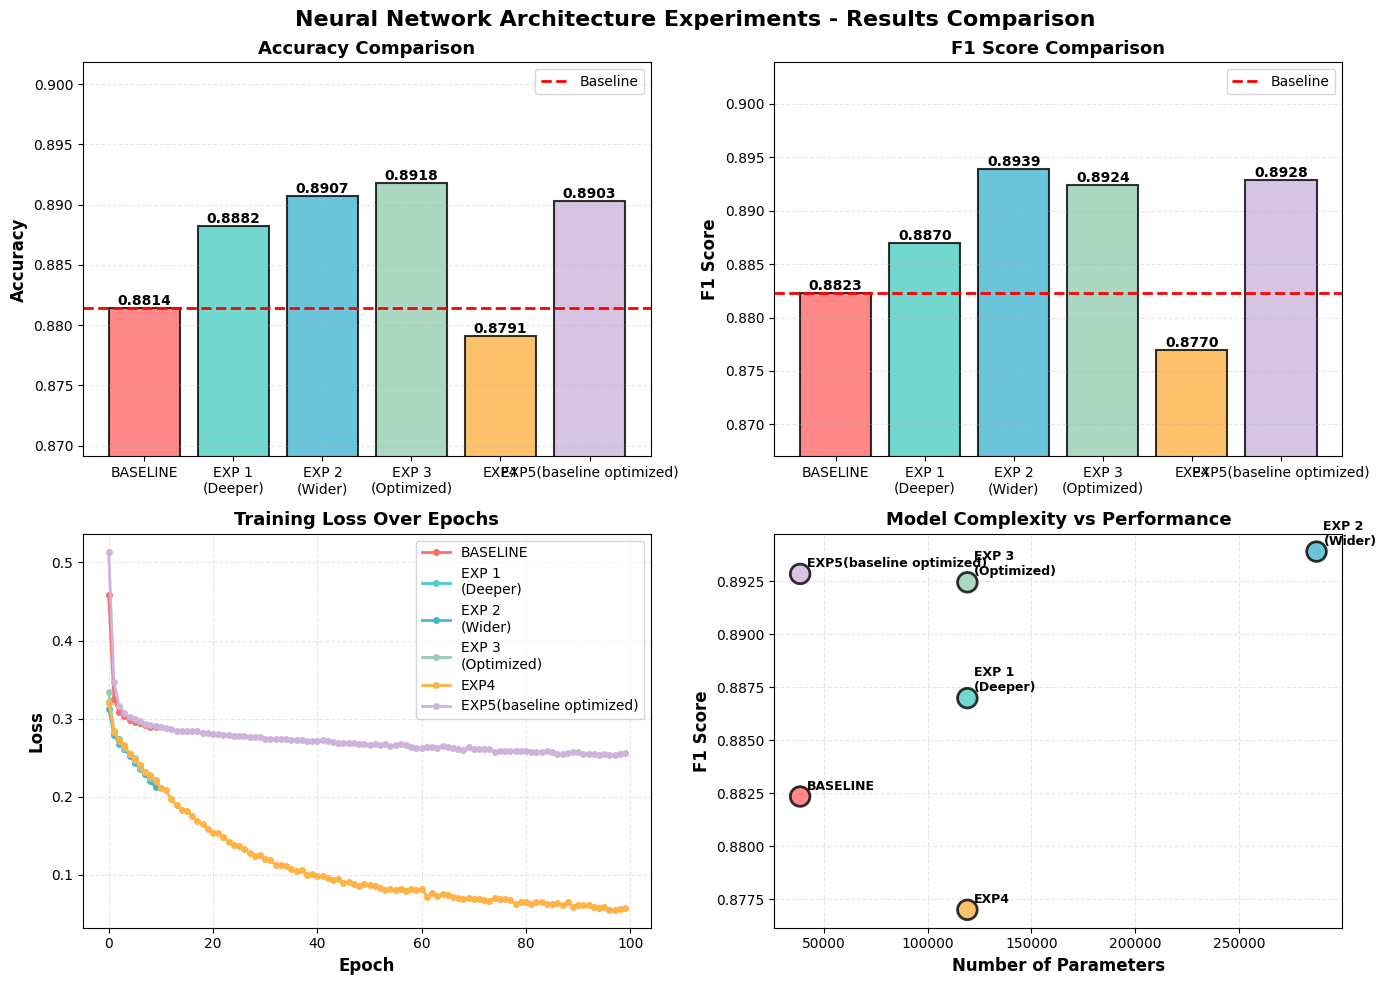

In [26]:
import matplotlib.pyplot as plt
print("\n" + "="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Neural Network Architecture Experiments - Results Comparison', 
             fontsize=16, fontweight='bold')

names = ['BASELINE', 'EXP 1\n(Deeper)', 'EXP 2\n(Wider)', 'EXP 3\n(Optimized)', 'EXP4','EXP5(baseline optimized)']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4','#FFB347','#CDB4DB']

# Plot 1: Accuracy Comparison
ax = axes[0, 0]
accuracies = [r['accuracy'] for r in results]
bars = ax.bar(names, accuracies, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Accuracy Comparison', fontsize=13, fontweight='bold')
ax.set_ylim([min(accuracies) - 0.01, max(accuracies) + 0.01])
ax.axhline(y=baseline['accuracy'], color='red', linestyle='--', linewidth=2, label='Baseline')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend()

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: F1 Score Comparison
ax = axes[0, 1]
f1_scores = [r['f1'] for r in results]
bars = ax.bar(names, f1_scores, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
ax.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax.set_title('F1 Score Comparison', fontsize=13, fontweight='bold')
ax.set_ylim([min(f1_scores) - 0.01, max(f1_scores) + 0.01])
ax.axhline(y=baseline['f1'], color='red', linestyle='--', linewidth=2, label='Baseline')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend()

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Training Loss Curves
ax = axes[1, 0]
for i, r in enumerate(results):
    ax.plot(r['losses'], label=names[i], marker='o', linewidth=2, 
            markersize=4, color=colors[i])
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax.set_title('Training Loss Over Epochs', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, linestyle='--')

# Plot 4: Model Complexity vs Performance
ax = axes[1, 1]
params = [r['params'] for r in results]
scatter = ax.scatter(params, f1_scores, s=200, c=colors, edgecolor='black', 
                     linewidth=2, alpha=0.8, zorder=3)
ax.set_xlabel('Number of Parameters', fontsize=12, fontweight='bold')
ax.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax.set_title('Model Complexity vs Performance', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')

# Add labels for each point
for i, (x, y) in enumerate(zip(params, f1_scores)):
    ax.annotate(names[i], (x, y), xytext=(5, 5), textcoords='offset points',
                fontweight='bold', fontsize=9)

plt.tight_layout()

